In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import tqdm as tqdm

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D,MaxPooling2D, Dropout, Flatten, Activation, Input, Add
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report


import random
import time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #turn TF warnings

#offline usage of plotly
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

from IPython.display import clear_output
clear_output()


In [2]:
#for uniform results
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
#load datasets paths
path = '/kaggle/input/cxr-for-cptn/Dataset'
path2 = '/kaggle/input/more-healthy-cxr'

In [4]:
print("Outputs for the provided paths")
print(os.listdir(path))
print(os.listdir(path2))

Outputs for the provided paths
['PNEUMONIA', 'TUBERCULOSIS', 'NORMAL', 'COVID-19']
['NORMAL']


We have two normal instances from both datasets, we will combine them together in a dataframe

In [5]:
#create a dataframe to house the two datasets
#1. The path with 4 different datasets
images = []
labels = []

for label in os.listdir(path):
    label_dir = os.path.join(path, label)
    for img in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img)
        images.append(img_path)
        labels.append(label)
    images, labels = shuffle(images,labels)

In [6]:
len(labels)

10172

In [7]:
len(images)

10172

In [8]:
#2. The path with Normal instances alone
for labl in os.listdir(path2):
    labl_path = os.path.join(path2, labl)
    for imgs in os.listdir(labl_path):
        imgs_path = os.path.join(labl_path,imgs)
        images.append(imgs_path)
        labels.append(labl)
    images, labels = shuffle(images, labels)
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame({'images':images, 'labels':labels})
df.head()

,images,labels
0,/kaggle/input/more-healthy-cxr/NORMAL/Normal-44.png,NORMAL
1,/kaggle/input/more-healthy-cxr/NORMAL/Normal-297.png,NORMAL
2,/kaggle/input/cxr-for-cptn/Dataset/COVID-19/COVID-2848.png,COVID-19
3,/kaggle/input/cxr-for-cptn/Dataset/COVID-19/COVID-692.png,COVID-19
4,/kaggle/input/more-healthy-cxr/NORMAL/Normal-2643.png,NORMAL


In [9]:
df.shape

(13188, 2)

In [10]:
print(df['labels'].value_counts().to_frame())

              count
labels             
NORMAL         4599
PNEUMONIA      4273
COVID-19       3616
TUBERCULOSIS    700


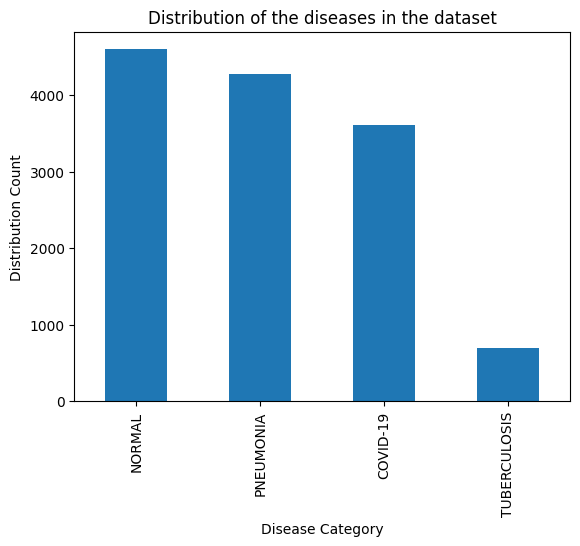

In [11]:
fig = plt.figure()
df['labels'].value_counts().plot(kind = "bar")
plt.xlabel("Disease Category")
plt.ylabel("Distribution Count")
plt.title("Distribution of the diseases in the dataset")
plt.show()

> The dataset is highly imbalanced with TB instances being highly affected. To handle this, we will combine two approaches to handling this: use of stratified sampling and average weighting approach.

# Pre-processing

In [12]:
train_val, test = train_test_split(df, test_size=0.1, stratify=df['labels'], random_state=42)
train, val_df = train_test_split(train_val, test_size=0.1, stratify=train_val['labels'], random_state=42)
print("The respective sizes of train, test and validation sets are:")
print("Train set:", len(train))
print("Test set:", len(test))
print("Validation set:", len(val_df))

The respective sizes of train, test and validation sets are:
Train set: 10682
Test set: 1319
Validation set: 1187


In [13]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    brightness_range=(0.64, 1.37),
    vertical_flip=True,
    horizontal_flip = True
)

In [14]:
train_gen = datagen.flow_from_dataframe(
    dataframe=train,
    directory = None,
    x_col="images",
    y_col="labels",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(299,299)
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="images",
    y_col="labels",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(299,299)
)

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=None,
    x_col="images",
    y_col="labels",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(299,299)
)


Found 10682 validated image filenames belonging to 4 classes.
Found 1187 validated image filenames belonging to 4 classes.
Found 1319 validated image filenames.


In [21]:
base_resnet = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (299,299,3)))
for layer in base_resnet.layers[:-10]:
    layers.trainable=False
hm = base_resnet.output
hm = AveragePooling2D(pool_size=(4,4))(hm)
hm = Flatten(name = 'flatten')(hm)
hm = Dense(256, activation = 'relu')(hm)
hm = Dropout(0.3)(hm)
hm = Dense(128, activation = 'relu')(hm)
hm = Dropout(0.2)(hm)
hm = Dense(4,activation = 'softmax')(hm)
resnet_model = Model(inputs=base_resnet.input, outputs = hm)

Class weighting approach in our case makes use of categorical cross entropy loss.

In [22]:
LABELS = ['NORMAL', 'TUBERCULOSIS', 'PNEUMONIA', 'COVID-19']
label_encoder = {'NORMAL': 0, 'TUBERCULOSIS': 1, 'PNEUMONIA': 2, 'COVID-19': 3}
label_decoder = {0: 'NORMAL', 1: 'TUBERCULOSIS', 2: 'PNEUMONIA', 3: 'COVID-19'}

In [23]:
class_weights = (train.labels.value_counts() / len(train)).to_dict()
class_weights = dict((label_encoder[key], value) for (key, value) in class_weights.items())
class_weights

{0: 0.3487174686388317,
 2: 0.32400299569369034,
 3: 0.2741995880921176,
 1: 0.05307994757536042}

Text(0.5, 1.0, 'Class Weights for Each Class')

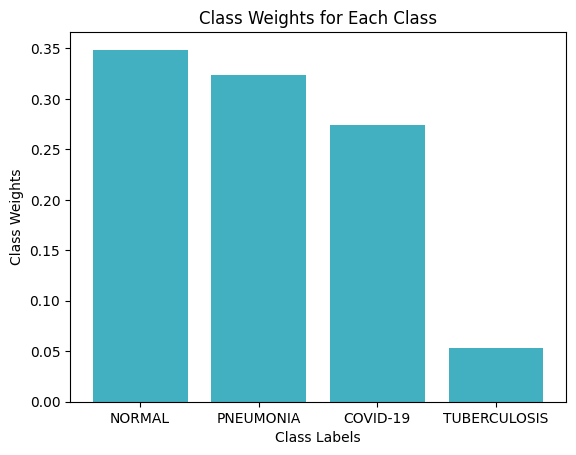

In [24]:
# distribution of the class weights
class_labels_w = [label_decoder[labels] for labels in class_weights.keys()]
weights = list(class_weights.values())

plt.bar(class_labels_w, weights, color='#43b0c1')
plt.xlabel('Class Labels')
plt.ylabel('Class Weights')
plt.title('Class Weights for Each Class')

Compile our model

In [25]:
batch_size = 32
from tensorflow.keras.optimizers import SGD
sgd_optimizer = SGD(learning_rate = 0.001)
resnet_model.compile(optimizer=sgd_optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/model.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose=1,
    save_best_only=True)


In [26]:
#train
epochs = 15
history = resnet_model.fit(
    train_gen,
    steps_per_epoch=train_gen.n//batch_size,
    validation_data=val_gen,
    validation_steps=val_gen.n//batch_size,
    epochs=epochs,
    verbose=1,
    class_weight = class_weights,
    callbacks=[model_checkpoint_callback]
    )

Epoch 1/15
333/333 [==============================] - ETA: 0s - loss: 0.2059 - accuracy: 0.4907
Epoch 1: val_accuracy improved from -inf to 0.27280, saving model to /kaggle/working/model.hdf5
333/333 [==============================] - 178s 485ms/step - loss: 0.2059 - accuracy: 0.4907 - val_loss: 1.4731 - val_accuracy: 0.2728
Epoch 2/15
333/333 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.6302
Epoch 2: val_accuracy improved from 0.27280 to 0.28378, saving model to /kaggle/working/model.hdf5
333/333 [==============================] - 162s 487ms/step - loss: 0.1153 - accuracy: 0.6302 - val_loss: 1.5050 - val_accuracy: 0.2838
Epoch 3/15
333/333 [==============================] - ETA: 0s - loss: 0.0909 - accuracy: 0.6925
Epoch 3: val_accuracy improved from 0.28378 to 0.62247, saving model to /kaggle/working/model.hdf5
333/333 [==============================] - 154s 461ms/step - loss: 0.0909 - accuracy: 0.6925 - val_loss: 0.9815 - val_accuracy: 0.6225
Epoch 4/15
33